# 6章 学習に関するテクニック

In [1]:
using Gadfly

In [2]:
function numerical_gradient{T,N}(f, x::AbstractArray{T,N})
    h = T(1e-4) # 0.0001
    # (f(x+h) - f(x-h)) / 2h
    reshape(map(1:length(x)) do idx
        tmp_val = x[idx]
        # f(x+h)
        x[idx] += h
        fxh1 = f(x)
        # f(x-h)
        x[idx] -= 2h
        fxh2 = f(x)
        # restore
        x[idx] = tmp_val
        (fxh1 - fxh2) / 2h
    end, size(x))
end

numerical_gradient (generic function with 1 method)

In [3]:
f(x, y) = x^2/20 + y^2

f (generic function with 1 method)

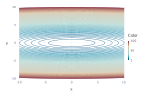

In [4]:
plot(z=f, x=linspace(-10, 10, 100), y=linspace(-10, 10, 100), Geom.contour(levels=0:100))

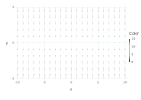

In [5]:
a0 = [-2.0:0.25:2.0;]
x = repmat(-10.0:10.0,11)
y = vec(repmat((-5.0:5.0)',21))
f2(x::Vector) = f(x...)
gxy = mapslices(v->numerical_gradient(f2, v), [x y;], 2)
exy = [x y;] - 2gxy ./ 3maximum(gxy)
c = mapslices(norm, gxy, 2)
plot(
x=x, y=y, xend=exy[:,1], yend=exy[:,2], color=c, Geom.vector, 
# Guide.xlabel("x1"), Guide.ylabel("x2"), 
Scale.x_continuous(minvalue=-10.0, maxvalue=10.0),
Scale.y_continuous(minvalue=-5.0, maxvalue=5.0),
Coord.cartesian(xmin=-10.0, xmax=10.0, ymin=-5.0, ymax=5.0))

In [6]:
numerical_gradient(f2, Float32[-7.0, 2.0])

2-element Array{Float32,1}:
 -0.698566
  4.00066 

## 6.1 パラメータの更新

In [7]:
abstract AbstractOptimizer{T<:AbstractFloat}

### 6.1.2 SGD

In [8]:
immutable SGD{T<:AbstractFloat} <: AbstractOptimizer{T}
    lr::T
end

(::Type{SGD{T}}){T}(lr::T=T(0.01)) = SGD(lr)

In [9]:
function update{T,N}(optimizer::SGD{T}, param::AbstractArray{T,N}, grad::AbstractArray{T,N})
    # @assert size(param) == size(grad)
    param - optimizer.lr .* grad
end

update (generic function with 1 method)

In [10]:
xs = Float32[]
ys = Float32[]
optimizer = SGD(Float32(0.95))

SGD{Float32}(0.95f0)

In [11]:
param = Float32[-7.0, 2.0]
append!(xs, param[1])
append!(ys, param[2])
for _=1:30
    grad = numerical_gradient(f2, param)
    param = update(optimizer, param, grad)
    append!(xs, param[1])
    append!(ys, param[2])
end

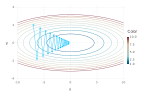

In [12]:
plot(
layer(x=xs, y=ys, Geom.point, Geom.line),
layer(z=f, x=linspace(-10, 10, 100), y=linspace(-5, 5, 100), Geom.contour(levels=0:10))
)

### 6.1.4 Momentum

In [13]:
immutable Momentum{T<:AbstractFloat} <: AbstractOptimizer{T}
    lr::T
    momentum::T
end

(::Type{Momentum{T}}){T}(lr::T=T(0.01), momentum::T=T(0.9)) = Momentum(lr, momentum)
(::Type{Momentum}){T}(lr::T) = Momentum(lr, T(0.9))

In [14]:
function update{T,N}(optimizer::Momentum{T}, v::AbstractArray{T,N}, param::AbstractArray{T,N}, grad::AbstractArray{T,N})
    # @assert size(v) == size(param) == size(grad)
    new_v = optimizer.momentum .* v .- optimizer.lr .* grad
    (new_v, param .+ new_v)
end

update (generic function with 2 methods)

In [15]:
xs = Float32[]
ys = Float32[]
optimizer = Momentum(Float32(0.1), Float32(0.9))

Momentum{Float32}(0.1f0,0.9f0)

In [16]:
param = Float32[-7.0, 2.0]
append!(xs, param[1])
append!(ys, param[2])
v = zeros(param)
for _=1:30
    grad = numerical_gradient(f2, param)
    (v, param) = update(optimizer, v, param, grad)
    append!(xs, param[1])
    append!(ys, param[2])
end

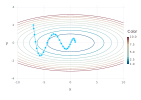

In [17]:
plot(
layer(x=xs, y=ys, Geom.point, Geom.line),
layer(z=f, x=linspace(-10, 10, 100), y=linspace(-5, 5, 100), Geom.contour(levels=0:10))
)

### 6.1.5 AdaGrad

In [18]:
immutable AdaGrad{T<:AbstractFloat} <: AbstractOptimizer{T}
    lr::T
end

(::Type{AdaGrad{T}}){T}(lr::T=T(0.01)) = AdaGrad(lr)

In [19]:
function update{T,N}(optimizer::AdaGrad{T}, h::AbstractArray{T,N}, param::AbstractArray{T,N}, grad::AbstractArray{T,N})
    # @assert size(h) == size(param) == size(grad)
    δ = T(1e-7)
    new_h = h .+ grad .* grad
    (new_h, param .- optimizer.lr .* grad ./ (sqrt.(new_h) + δ))
end

update (generic function with 3 methods)

In [20]:
xs = Float32[]
ys = Float32[]
optimizer = AdaGrad(Float32(1.5))

AdaGrad{Float32}(1.5f0)

In [21]:
param = Float32[-7.0, 2.0]
append!(xs, param[1])
append!(ys, param[2])
h = zeros(param)
for _=1:30
    grad = numerical_gradient(f2, param)
    (h, param) = update(optimizer, h, param, grad)
    append!(xs, param[1])
    append!(ys, param[2])
end

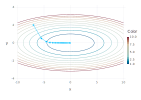

In [22]:
plot(
layer(x=xs, y=ys, Geom.point, Geom.line),
layer(z=f, x=linspace(-10, 10, 100), y=linspace(-5, 5, 100), Geom.contour(levels=0:10))
)

### 6.1.6 Adam

In [23]:
immutable Adam{T<:AbstractFloat} <: AbstractOptimizer{T}
    lr::T
    β1::T
    β2::T
end

(::Type{Adam{T}}){T}(lr::T=T(0.001)) = Adam(lr,T(0.9),T(0.999))
(::Type{Adam}){T}(lr::T,β1::T=T(0.9),β2::T=T(0.999)) = Adam(lr,β1,β2)

In [24]:
Adam(Float32(0.001))

Adam{Float32}(0.001f0,0.9f0,0.999f0)

In [25]:
type AdamParams{T}
    iter::Int
    m::AbstractArray{T}
    v::AbstractArray{T}
end

In [26]:
function update{T,N}(optimizer::Adam{T}, ap::AdamParams{T}, param::AbstractArray{T,N}, grad::AbstractArray{T,N})
    # @assert size(h) == size(param) == size(grad)
    δ = T(1e-7)
    new_iter = ap.iter + 1
    lr_t = optimizer.lr * sqrt(one(T) - optimizer.β2^new_iter) / (1.0 - optimizer.β1^new_iter)
    new_m = ap.m .+ (1 - optimizer.β1) .* (grad .- ap.m)
    new_v = ap.v .+ (1 - optimizer.β2) .* (grad.^2 .- ap.v)
    new_ap = AdamParams(new_iter, new_m, new_v)
    (new_ap, param .- lr_t .* new_m ./ (sqrt.(new_v) + δ))
end

update (generic function with 4 methods)

In [27]:
xs = Float32[]
ys = Float32[]
optimizer = Adam(Float32(0.3))

Adam{Float32}(0.3f0,0.9f0,0.999f0)

In [28]:
param = Float32[-7.0, 2.0]
append!(xs, param[1])
append!(ys, param[2])
ap = AdamParams(0, zeros(param), zeros(param))
for _=1:30
    grad = numerical_gradient(f2, param)
    (ap, param) = update(optimizer, ap, param, grad)
    append!(xs, param[1])
    append!(ys, param[2])
end

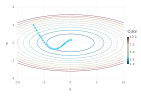

In [29]:
plot(
layer(x=xs, y=ys, Geom.point, Geom.line),
layer(z=f, x=linspace(-10, 10, 100), y=linspace(-5, 5, 100), Geom.contour(levels=0:10))
)

### 6.1.8 MNIST データセットによる更新手法の比較

In [30]:
include("layers.jl");
include("multilayernet.jl");

In [31]:
abstract AbstractOptimizerStatus{T<:AbstractFloat}

In [32]:
immutable SGDStatus{T<:AbstractFloat} <: AbstractOptimizerStatus{T}
    lr::T
end

In [33]:
initializestatus{T}(optimizer::SGD{T}, ::MultiLayerNet{T}) = SGDStatus(optimizer.lr)

initializestatus (generic function with 1 method)

In [34]:
updatestatus{T}(optimizer::SGD{T}, status::SGDStatus{T}, ::MultiLayerNetGrads{T}) = status

updatestatus (generic function with 1 method)

In [35]:
function getparams{T}(net::MultiLayerNet{T})
    Ws = AbstractMatrix{T}[lyr.W for lyr=net.fclyrs]
    bs = AbstractVector{T}[lyr.b for lyr=net.fclyrs]
    MultiLayerNetParams(Ws, bs)
end

getparams (generic function with 1 method)

In [36]:
immutable MomentumStatus{T<:AbstractFloat} <: AbstractOptimizerStatus{T}
    lr::T
    v::MultiLayerNetParams{T}
end

In [37]:
function initializestatus{T}(
        optimizer::Momentum{T}, 
        net::MultiLayerNet{T})
    Ws = AbstractMatrix{T}[zeros(lyr.W) for lyr=net.fclyrs]
    bs = AbstractVector{T}[zeros(lyr.b) for lyr=net.fclyrs]
    params = MultiLayerNetParams(Ws, bs)
    MomentumStatus(optimizer.lr, params)
end

initializestatus (generic function with 2 methods)

In [38]:
function updatestatus{T}(
        optimizer::Momentum{T}, 
        status::MomentumStatus{T}, 
        grads::MultiLayerNetGrads{T})
    # new_v = optimizer.momentum .* v .- optimizer.lr .* grad
    Ws = AbstractMatrix{T}[optimizer.momentum .* status.v.Ws[i] .- optimizer.lr .* grads.Ws[i] for i=1:length(grads.Ws)]
    bs = AbstractVector{T}[optimizer.momentum .* status.v.bs[i] .- optimizer.lr .* grads.bs[i] for i=1:length(grads.bs)]
    params = MultiLayerNetParams(Ws, bs)
    MomentumStatus(optimizer.lr, params)
end

updatestatus (generic function with 2 methods)

In [39]:
immutable AdaGradStatus{T<:AbstractFloat} <: AbstractOptimizerStatus{T}
    lr::T
    h::MultiLayerNetParams{T}
end

In [40]:
function initializestatus{T}(
    optimizer::AdaGrad{T}, 
    net::MultiLayerNet{T})
    Ws = AbstractMatrix{T}[zeros(lyr.W) for lyr=net.fclyrs]
    bs = AbstractVector{T}[zeros(lyr.b) for lyr=net.fclyrs]
    params = MultiLayerNetParams(Ws, bs)
    AdaGradStatus(optimizer.lr, params)
end

initializestatus (generic function with 3 methods)

In [41]:
function updatestatus{T}(
        optimizer::AdaGrad{T}, 
        status::AdaGradStatus{T}, 
        grads::MultiLayerNetGrads{T})
    # δ = T(1e-7)
    # new_h = h .+ grad .* grad
    # (new_h, param .- optimizer.lr .* grad ./ (sqrt.(new_h) + δ))
    Ws = AbstractMatrix{T}[status.h.Ws[i] .+ grads.Ws[i].^2 for i=1:length(grads.Ws)]
    bs = AbstractVector{T}[status.h.bs[i] .+ grads.bs[i].^2 for i=1:length(grads.bs)]
    params = MultiLayerNetParams(Ws, bs)
    AdaGradStatus(optimizer.lr, params)
end

updatestatus (generic function with 3 methods)

In [42]:
immutable AdamStatus{T<:AbstractFloat} <: AbstractOptimizerStatus{T}
    lr::T
    β1::T
    β2::T
    iter::Int
    m::MultiLayerNetParams{T}
    v::MultiLayerNetParams{T}
end

In [43]:
function initializestatus{T}(
    optimizer::Adam{T}, 
    net::MultiLayerNet{T})
    mWs = AbstractMatrix{T}[zeros(lyr.W) for lyr=net.fclyrs]
    mbs = AbstractVector{T}[zeros(lyr.b) for lyr=net.fclyrs]
    m = MultiLayerNetParams(mWs, mbs)
    vWs = AbstractMatrix{T}[zeros(lyr.W) for lyr=net.fclyrs]
    vbs = AbstractVector{T}[zeros(lyr.b) for lyr=net.fclyrs]
    v = MultiLayerNetParams(vWs, vbs)
    AdamStatus(optimizer.lr, optimizer.β1, optimizer.β2, 0, m, v)
end

initializestatus (generic function with 4 methods)

In [44]:
function updatestatus{T}(
        optimizer::Adam{T}, 
        status::AdamStatus{T}, 
        grads::MultiLayerNetGrads{T})
    # δ = T(1e-7)
    iter = status.iter + 1
    mWs = AbstractMatrix{T}[status.m.Ws[i] .+ (1 - optimizer.β1) .* (grads.Ws[i] .- status.m.Ws[i]) for i=1:length(grads.Ws)]
    mbs = AbstractVector{T}[status.m.bs[i] .+ (1 - optimizer.β1) .* (grads.bs[i] .- status.m.bs[i]) for i=1:length(grads.bs)]
    m = MultiLayerNetParams(mWs, mbs)
    vWs = AbstractMatrix{T}[status.v.Ws[i] .+ (1 - optimizer.β2) .* (grads.Ws[i].^2 .- status.v.Ws[i]) for i=1:length(grads.Ws)]
    vbs = AbstractVector{T}[status.v.bs[i] .+ (1 - optimizer.β2) .* (grads.bs[i].^2 .- status.v.bs[i]) for i=1:length(grads.bs)]
    v = MultiLayerNetParams(vWs, vbs)
    AdamStatus(optimizer.lr, optimizer.β1, optimizer.β2, iter, m, v)
end

updatestatus (generic function with 4 methods)

In [45]:
using MNIST

In [46]:
function onehot(t::AbstractVector, l::AbstractVector)
    r = zeros(Int, length(l), length(t))
    for i = 1:length(t)
        r[findfirst(l, t[i]), i] = 1
    end
    r
end
function onehot{T}(::Type{T}, t::AbstractVector, l::AbstractVector)
    r = zeros(T, length(l), length(t))
    for i = 1:length(t)
        r[findfirst(l, t[i]), i] = one(T)
    end
    r
end

onehot (generic function with 2 methods)

In [47]:
function applygradient!{T}(net::MultiLayerNet{T}, grads::MultiLayerNetGrads{T}, status::SGDStatus{T})
    N = length(net.fclyrs)
    for i=1:N
        net.fclyrs[i].W .-= status.lr .* grads.Ws[i]
        net.fclyrs[i].b .-= status.lr .* grads.bs[i]
    end
end

applygradient! (generic function with 2 methods)

In [48]:
function applygradient!{T}(net::MultiLayerNet{T}, grads::MultiLayerNetGrads{T}, status::MomentumStatus{T})
    N = length(net.fclyrs)
    for i=1:N
        net.fclyrs[i].W .+= status.v.Ws[i]
        net.fclyrs[i].b .+= status.v.bs[i]
    end
end

applygradient! (generic function with 3 methods)

In [49]:
function applygradient!{T}(net::MultiLayerNet{T}, grads::MultiLayerNetGrads{T}, status::AdaGradStatus{T})
    δ = T(1e-7)
    N = length(net.fclyrs)
    for i=1:N
        net.fclyrs[i].W .-= status.lr .* grads.Ws[i] ./ (sqrt.(status.h.Ws[i]) + δ)
        net.fclyrs[i].b .-= status.lr .* grads.bs[i] ./ (sqrt.(status.h.bs[i]) + δ)
    end
end

applygradient! (generic function with 4 methods)

In [50]:
function applygradient!{T}(net::MultiLayerNet{T}, ::MultiLayerNetGrads{T}, status::AdamStatus{T})
    δ = T(1e-7)
    lr_t = status.lr * sqrt(one(T) - status.β2^status.iter) / (1.0 - status.β1^status.iter)
    N = length(net.fclyrs)
    for i=1:N
        net.fclyrs[i].W .-= lr_t .* status.m.Ws[i] ./ (sqrt.(status.v.Ws[i]) + δ)
        net.fclyrs[i].b .-= lr_t .* status.m.bs[i] ./ (sqrt.(status.v.bs[i]) + δ)
    end
end

applygradient! (generic function with 5 methods)

In [51]:
function train{T,F<:Function}(
        cb::F, 
        net::MultiLayerNet{T}, 
        x_train::AbstractMatrix{T}, 
        t_train::AbstractMatrix{T};
        optimizer::AbstractOptimizer{T}=SGD{T}(),
        iters_num::Int=1000,
        batch_size::Int=100)
    train_size = size(x_train, 2);
    status = initializestatus(optimizer, net)
    for i = 1:iters_num
        batch_mask = rand(1:train_size, batch_size)
        x_batch = x_train[:, batch_mask]
        t_batch = t_train[:, batch_mask]

        # 誤差逆伝播法
        grads = gradient(net, x_batch, t_batch)

        # 更新
        status = updatestatus(optimizer, status, grads)
        applygradient!(net, grads, status)
        
        # コールバック
        _loss = loss(net, x_batch, t_batch)
        cb(net, i, _loss, status)
    end
end

train (generic function with 1 method)

In [52]:
_x_train, _t_train = traindata();
_x_test, _t_test = testdata();
x_train = collect(Float32, _x_train) ./ 255
t_train = onehot(Float32, _t_train, 0:9)
x_test = collect(Float32, _x_test) ./ 255
t_test = onehot(Float32, _t_test, 0:9);

In [53]:
net1 = MultiLayerNet{Float32}(784, [100, 100, 100], 10)

MultiLayerNet{Float32}(AffineLayer{Float32}[AffineLayer{Float32}(Float32[0.00305224 0.0311707 … -0.0391684 0.010714; 0.110872 0.0026451 … 0.081005 0.012642; … ; 0.00306589 0.0391698 … -0.0621144 -0.0086764; -0.00408181 0.0544097 … -0.00146869 0.071728],Float32[0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0  …  0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0],#undef,#undef,#undef),AffineLayer{Float32}(Float32[0.245685 0.138902 … -0.147046 -0.169546; 0.175419 -0.0567242 … 0.0719809 -0.274051; … ; 0.0937334 -0.163143 … 0.0503011 -0.0499642; 0.312525 0.108757 … 0.0300874 0.0132306],Float32[0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0  …  0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0],#undef,#undef,#undef),AffineLayer{Float32}(Float32[-0.000906773 -0.0783998 … 0.19056 0.240245; 0.265665 -0.113064 … -0.265024 -0.0273908; … ; 0.113201 -0.0336017 … 0.109473 -0.0252046; -0.0595145 0.109031 … -0.0861111 -0.0397583],Float32[0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0  …  0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0],#undef,#undef,

In [54]:
optimizer1 = SGD{Float32}()

SGD{Float32}(0.01f0)

In [55]:
train_loss_list1 = Float32[];
train_acc_list1 = Float32[];
test_acc_list1 = Float32[];
train_size = size(x_train, 2);
batch_size = 128
iter_per_epoch = max(train_size ÷ batch_size, 1)

train(net1, x_train, t_train; optimizer=optimizer1, iters_num=2000, batch_size=128) do net, i, _loss, _
    push!(train_loss_list1, _loss)
    if i % iter_per_epoch == 1
        train_acc = accuracy(net, x_train, t_train)
        test_acc = accuracy(net, x_test, t_test)
        push!(train_acc_list1, train_acc)
        push!(test_acc_list1, test_acc)
        println("$(i-1): train_acc=$(train_acc) / test_acc=$(test_acc)")
    end
end

0: train_acc=0.11348333333333334 / test_acc=0.1139
468: train_acc=0.8678333333333333 / test_acc=0.8746
936: train_acc=0.9004833333333333 / test_acc=0.9056
1404: train_acc=0.91595 / test_acc=0.918
1872: train_acc=0.9235833333333333 / test_acc=0.9265


In [56]:
final_train_acc = accuracy(net1, x_train, t_train)
final_test_acc = accuracy(net1, x_test, t_test)
push!(train_acc_list1, final_train_acc)
push!(test_acc_list1, final_test_acc)
println("final: train_acc=$(final_train_acc) / test_acc=$(final_test_acc)")

final: train_acc=0.9255166666666667 / test_acc=0.9279


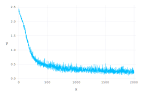

In [57]:
plot(x=1:length(train_loss_list1), y=train_loss_list1, Geom.line)

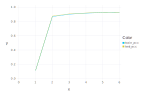

In [58]:
xs = [1:length(train_acc_list1);]
y1 = train_acc_list1
y2 = test_acc_list1
c1 = repmat(["train_acc"], length(xs))
c2 = repmat(["test_acc"], length(xs))
plot(x=[xs;xs], y=[y1;y2], color=[c1;c2], Geom.line)

In [59]:
net2 = MultiLayerNet{Float32}(784, [100, 100, 100], 10)

MultiLayerNet{Float32}(AffineLayer{Float32}[AffineLayer{Float32}(Float32[-0.0643631 0.0705527 … 0.0496275 0.0222364; 0.0115984 -0.0563212 … 0.00252518 -0.0216735; … ; 0.0306495 -0.0308101 … 0.108647 0.0154585; 0.0577193 -0.0275574 … -0.00851908 -0.0671877],Float32[0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0  …  0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0],#undef,#undef,#undef),AffineLayer{Float32}(Float32[0.0795158 -0.0681757 … -0.0506315 0.114414; -0.0493981 0.010719 … 0.207899 -0.317098; … ; -0.0760564 -0.246702 … -0.044153 0.0574298; -0.235447 -0.0453273 … -0.0156715 0.282892],Float32[0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0  …  0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0],#undef,#undef,#undef),AffineLayer{Float32}(Float32[-0.170407 0.225686 … -0.121495 -0.0800611; 0.0730155 -0.0301687 … -0.00749598 -0.179527; … ; 0.174487 -0.0706684 … 0.122467 0.0642728; 0.00983579 0.0296932 … 0.082876 0.0507423],Float32[0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0  …  0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0],#undef

In [60]:
optimizer2 = Momentum{Float32}()

Momentum{Float32}(0.01f0,0.9f0)

In [61]:
train_loss_list2 = Float32[];
train_acc_list2 = Float32[];
test_acc_list2 = Float32[];
# train_size = size(x_train, 2);
# batch_size = 128
# iter_per_epoch = max(train_size ÷ batch_size, 1)

train(net2, x_train, t_train; optimizer=optimizer2, iters_num=2000, batch_size=128) do net, i, _loss, _
    push!(train_loss_list2, _loss)
    if i % iter_per_epoch == 1
        train_acc = accuracy(net, x_train, t_train)
        test_acc = accuracy(net, x_test, t_test)
        push!(train_acc_list2, train_acc)
        push!(test_acc_list2, test_acc)
        println("$(i-1): train_acc=$(train_acc) / test_acc=$(test_acc)")
    end
end

0: train_acc=0.09976666666666667 / test_acc=0.0988
468: train_acc=0.9416333333333333 / test_acc=0.9404
936: train_acc=0.9532333333333334 / test_acc=0.9487
1404: train_acc=0.9704833333333334 / test_acc=0.9648
1872: train_acc=0.9741 / test_acc=0.9682


In [62]:
final_train_acc = accuracy(net2, x_train, t_train)
final_test_acc = accuracy(net2, x_test, t_test)
push!(train_acc_list2, final_train_acc)
push!(test_acc_list2, final_test_acc)
println("final: train_acc=$(final_train_acc) / test_acc=$(final_test_acc)")

final: train_acc=0.9747 / test_acc=0.9649


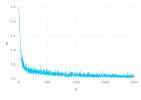

In [63]:
plot(x=1:length(train_loss_list2), y=train_loss_list2, Geom.line)

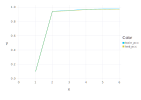

In [64]:
xs = [1:length(train_acc_list2);]
y1 = train_acc_list2
y2 = test_acc_list2
c1 = repmat(["train_acc"], length(xs))
c2 = repmat(["test_acc"], length(xs))
plot(x=[xs;xs], y=[y1;y2], color=[c1;c2], Geom.line)

In [65]:
net3 = MultiLayerNet{Float32}(784, [100, 100, 100], 10)

MultiLayerNet{Float32}(AffineLayer{Float32}[AffineLayer{Float32}(Float32[-0.0419122 -0.00854858 … -0.103327 -0.00349222; -0.00985337 0.0600906 … 0.096093 0.172494; … ; 0.022384 -0.0440694 … 0.0551862 -0.0627416; -0.026845 -0.024852 … 0.0399462 -0.0303712],Float32[0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0  …  0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0],#undef,#undef,#undef),AffineLayer{Float32}(Float32[-0.0738577 -0.0861915 … 0.0837053 -0.0269535; -0.0594459 0.172021 … -0.018176 -0.0892011; … ; 0.0970935 -0.128299 … 0.0295008 0.136591; 0.106904 -0.0417704 … -0.0358655 0.217819],Float32[0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0  …  0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0],#undef,#undef,#undef),AffineLayer{Float32}(Float32[0.0486046 0.118074 … -0.0150453 0.1508; -0.128683 -0.0868088 … 0.291598 0.0553513; … ; -0.138272 -0.173087 … -0.12906 0.118339; 0.0482287 0.201241 … -0.0867263 0.0232185],Float32[0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0  …  0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0],#undef,#undef

In [66]:
optimizer3 = AdaGrad{Float32}()

AdaGrad{Float32}(0.01f0)

In [67]:
train_loss_list3 = Float32[];
train_acc_list3 = Float32[];
test_acc_list3 = Float32[];
# train_size = size(x_train, 2);
# batch_size = 128
# iter_per_epoch = max(train_size ÷ batch_size, 1)

train(net3, x_train, t_train; optimizer=optimizer3, iters_num=2000, batch_size=128) do net, i, _loss, _
    push!(train_loss_list3, _loss)
    if i % iter_per_epoch == 1
        train_acc = accuracy(net, x_train, t_train)
        test_acc = accuracy(net, x_test, t_test)
        push!(train_acc_list3, train_acc)
        push!(test_acc_list3, test_acc)
        println("$(i-1): train_acc=$(train_acc) / test_acc=$(test_acc)")
    end
end

0: train_acc=0.20511666666666667 / test_acc=0.2063
468: train_acc=0.95755 / test_acc=0.9511
936: train_acc=0.9697833333333333 / test_acc=0.964
1404: train_acc=0.9777166666666667 / test_acc=0.9696
1872: train_acc=0.9809 / test_acc=0.9726


In [68]:
final_train_acc = accuracy(net3, x_train, t_train)
final_test_acc = accuracy(net3, x_test, t_test)
push!(train_acc_list3, final_train_acc)
push!(test_acc_list3, final_test_acc)
println("final: train_acc=$(final_train_acc) / test_acc=$(final_test_acc)")

final: train_acc=0.98145 / test_acc=0.9712


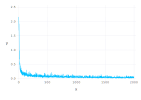

In [69]:
plot(x=1:length(train_loss_list3), y=train_loss_list3, Geom.line)

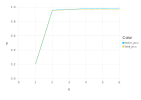

In [70]:
xs = [1:length(train_acc_list3);]
y1 = train_acc_list3
y2 = test_acc_list3
c1 = repmat(["train_acc"], length(xs))
c2 = repmat(["test_acc"], length(xs))
plot(x=[xs;xs], y=[y1;y2], color=[c1;c2], Geom.line)

In [71]:
net4 = MultiLayerNet{Float32}(784, [100, 100, 100], 10)

MultiLayerNet{Float32}(AffineLayer{Float32}[AffineLayer{Float32}(Float32[-0.0107705 0.0188436 … -0.0411596 -0.0514571; -0.0175166 0.00276027 … -0.0559295 0.0485068; … ; 0.0528405 0.00878949 … -0.0647301 -0.0626345; -0.0390134 0.0150172 … -0.0814265 0.0332723],Float32[0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0  …  0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0],#undef,#undef,#undef),AffineLayer{Float32}(Float32[0.277394 0.221692 … -0.0301056 0.120069; -0.0793534 0.0416671 … 0.0517202 0.0712112; … ; -0.0098275 0.00209802 … -0.0922322 0.0611184; -0.0354596 0.0788613 … -0.226633 -0.0738991],Float32[0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0  …  0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0],#undef,#undef,#undef),AffineLayer{Float32}(Float32[-0.177266 -0.231455 … -0.152385 -0.296451; -0.274443 0.0687941 … -0.183968 -0.0164835; … ; -0.17159 0.164087 … 0.218526 0.360773; -0.0174074 -0.102043 … -0.266828 0.185758],Float32[0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0  …  0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0],#undef

In [72]:
optimizer4 = Adam{Float32}()

Adam{Float32}(0.001f0,0.9f0,0.999f0)

In [73]:
train_loss_list4 = Float32[];
train_acc_list4 = Float32[];
test_acc_list4 = Float32[];
# train_size = size(x_train, 2);
# batch_size = 128
# iter_per_epoch = max(train_size ÷ batch_size, 1)

train(net4, x_train, t_train; optimizer=optimizer4, iters_num=2000, batch_size=128) do net, i, _loss, _
    push!(train_loss_list4, _loss)
    if i % iter_per_epoch == 1
        train_acc = accuracy(net, x_train, t_train)
        test_acc = accuracy(net, x_test, t_test)
        push!(train_acc_list4, train_acc)
        push!(test_acc_list4, test_acc)
        println("$(i-1): train_acc=$(train_acc) / test_acc=$(test_acc)")
    end
end

0: train_acc=0.17071666666666666 / test_acc=0.1784
468: train_acc=0.9592333333333334 / test_acc=0.9555
936: train_acc=0.9737666666666667 / test_acc=0.9673
1404: train_acc=0.9789333333333333 / test_acc=0.9697
1872: train_acc=0.9851333333333333 / test_acc=0.9746


In [74]:
final_train_acc = accuracy(net4, x_train, t_train)
final_test_acc = accuracy(net4, x_test, t_test)
push!(train_acc_list4, final_train_acc)
push!(test_acc_list4, final_test_acc)
println("final: train_acc=$(final_train_acc) / test_acc=$(final_test_acc)")

final: train_acc=0.9853166666666666 / test_acc=0.9727


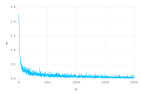

In [75]:
plot(x=1:length(train_loss_list4), y=train_loss_list4, Geom.line)

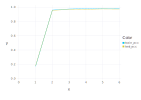

In [76]:
xs = [1:length(train_acc_list4);]
y1 = train_acc_list4
y2 = test_acc_list4
c1 = repmat(["train_acc"], length(xs))
c2 = repmat(["test_acc"], length(xs))
plot(x=[xs;xs], y=[y1;y2], color=[c1;c2], Geom.line)

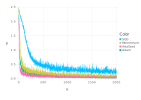

In [77]:
xs = [1:length(train_loss_list1);]
y1 = train_loss_list1
y2 = train_loss_list2
y3 = train_loss_list3
y4 = train_loss_list4
c1 = repmat(["SGD"], length(xs))
c2 = repmat(["Momentum"], length(xs))
c3 = repmat(["AdaGrad"], length(xs))
c4 = repmat(["Adam"], length(xs))
plot(x=[xs;xs;xs;xs], y=[y1;y2;y3;y4], color=[c1;c2;c3;c4], Geom.line)